In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

---

## Диагностика моделей классификации


Для первого примера воспользуемся синтетическими данными. Сгенерируем большой и достаточно сложный датасет для классификации. В нем будет 10 тысяч точек и 500 атрибутов. Из них всего 50 признаков будут информативными. Сразу после генерации разделим получившийся датасет на обучающую и тестовую выборки:


In [2]:
from sklearn.datasets import make_classification, make_regression

X, y = make_classification(
    n_samples=10000,
    n_features=500,
    n_informative=50,
    n_repeated=0,
    class_sep=1,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3
)

Обучим на этом наборе данных самую простую модель - логистическую регрессию. Выведем оценки точности этой модели на обучающей и тестовой выборке:


In [3]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, y_train)

В данном случае мы используем метрику эффективности классификации по умолчанию. В зависимости от задания вы можете проводить анализ по любой интересующей вас метрике. Получаем такие оценки эффективности данной модели:


In [4]:
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8413
Test score: 0.8056


То, насколько отличается обучающая и тестовая эффективность модели - основной индикатор пере- или недообучения. Мы явно видим, что тестовая эффективность полученной модели неидеальна. Определить, что является причиной снижения качества модели - ее излишняя или недостаточная вариативность - основная цель диагностики модели машинного обучения.

Но по одним этим показателям очень сложно понять, в какой из двух ситуаций мы находимся. Поэтому прибегнем к построению кривых обучения. Это даст нам больше информации о том, каков уровень сложности модели по отношению к данным. Воспользуемся готовой реализацией построения кривых обучения из библиотеки продвинутой визуализации для машинного обучения yellowbrick:


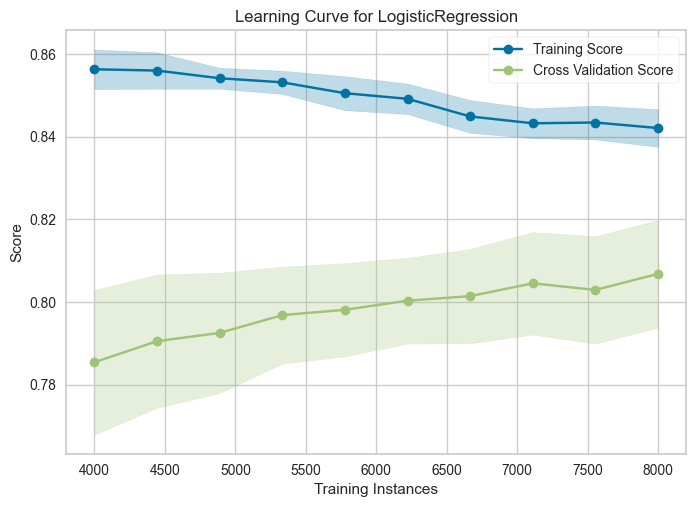

In [5]:
from yellowbrick.model_selection import LearningCurve

visualizer = (
    LearningCurve(LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10))
    .fit(X, y)
    .show()
)

Здесь мы задаем модель, которую хотим проверить и набор долей обучающей выборки, по которым будем ее обучать. В данном случае, эта функция построит модели логистической регрессии, обученные на 10%, 20%, и так далее до 100% обучающей выборки. А затем по каждой модели будет вычислена обучающая и тестовая эффективности. И эти показатели будут изображены на графике, то есть кривой обучения:

---


Эта кривая показывает, что когда модель учится на небольшом объеме данных, она имеет прекрасную обучающую эффективность, но плохую тестовую. По мере увеличения объема обучающей выборки, эти эффективности сближаются, но между ними все еще сохраняется зазор.

Напомним, что большой промежуток между тестовой и обучающей эффективностью свидетельствует о переобучении. А низкое значение обучающей эффективности - о недообучении. Так что из этого присутствует в данной модели? Можно предположить, что модель немного переобучается. В пользу этого говорит и то, что наш исходный датасет очень разреженный (хотя мы об этом знаем только потому, что его сгенерировали). Более точно можно будет сказать сравнив эту модель с другими. Самый простой способ - использовать регуляризацию.

МЫ воспользуемся классификатором на основе гребневой регрессии. Вспомним, что обычный метод наименьших квадратов (воплощением которого является модель логистической регрессии) эквивалентна гребневой модели с параметром регуляризации, равном нулю. Чем больше этот параметр, тем больше регуляризации в модели и тем проще получаемые модели. Если мы предполагаем, что наша исходная модель переобучалась, то давайте построим и оценим модель с большим значением параметра регуляризации:


In [6]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=1000000).fit(X_train, y_train)

При таком огромном значении регуляризации мы почти гарантированно получим недообученную модель. Поэтому полезно будет сравнить результаты модели выше с этими. Вот что получилось у очень регуляризованной модели:


In [7]:
print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.7724
Test score: 0.7712


Обратите внимание, что эффективность стала заметно ниже. Плюс, значения почти совпадают. То есть, почти никакой разницы не осталось. Это подтверждает наш первоначальный вывод о том, что в первой модели разница между обучающей и тестовой эффективностью получилась довольно большой для данной задачи. Построим кривые обучения для нашей второй модели:


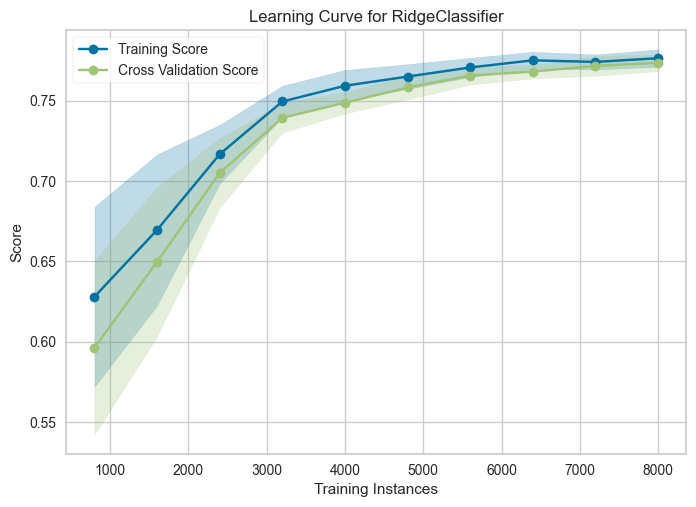

In [8]:
visualizer = (
    LearningCurve(RidgeClassifier(alpha=1000000), train_sizes=np.linspace(0.1, 1.0, 10))
    .fit(X, y)
    .show()
)

Получилась совсем другая картина


При анализе таких графиков надо обязательно обращать внимание на масштаб вертикальной оси. Несмотря на то, что кажется, будто значения в правой части графика (а нам интересны в первую очередь именно конечные значения эффективности, остальные - это просто предыстория) сильно больше, чем на первом, на самом деле они ниже. Данный график очень характерен для недообучения - низкие значения эффективности и практически никакой разницы между тестовой и обучающей эффективностью.

Если нерегуляризованная модель переобучается, а регуляризованная - недообучается, то где-то в промежутке есть оптимальная модель

Для того, чтобы проанализировать данную задачу еще более глубоко построим график зависимости эффективности модели от значения параметра регуляризации. Для этого воспользуется логравномерным распределением:


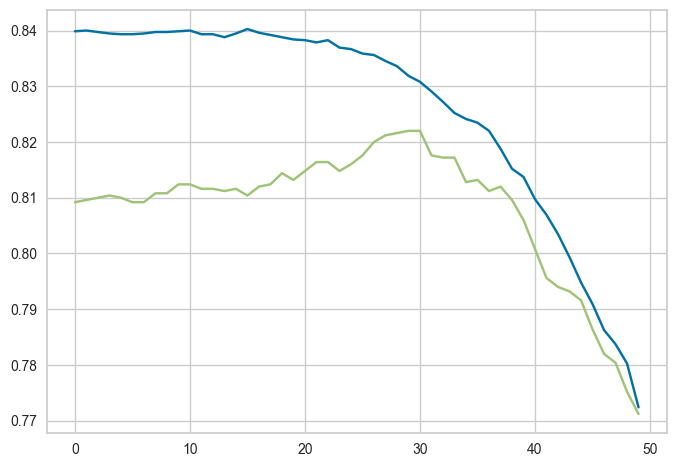

In [9]:
from sklearn.linear_model import RidgeClassifier

trains = []
tests = []
for i in np.logspace(2, 6, 50):
    ridge = RidgeClassifier(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains)
plt.plot(tests)

Данный код построит 50 моделей, различающихся только параметром регуляризации. Он будет лежать в диапазоне от 100 ($10^2$) до 1 000 000 ($10^6$). Диапазон подбирается эмпирически, интересующий нас интервал значений параметров регуляризации будет разный в других задачах. Поэтому рекомендуется сначала построить модели в очень широких пределах (скажем, от -6 до 6), а затем сужать его настолько, чтобы на графике наглядно проявилась примерно такая картина


Здесь мы видим, что при определенных значениях параметра регуляризации тестовая эффективность модели (а нас в конечном итоге интересует именно она) лучше, чем во всех остальных. Подбором или алгоритмически можно найти такое оптимальное значение параметра регуляризации. Оно дает нам модель, которая имеет оптимальный уровень сложности для данного конкретного датасета. Давайте выведем получившиеся показатели:


In [10]:
from sklearn.linear_model import RidgeClassifier

lr = RidgeClassifier(alpha=26500).fit(X_train, y_train)

print(f"Training score: {lr.score(X_train, y_train):.4f}")
print(f"Test score: {lr.score(X_test, y_test):.4f}")

Training score: 0.8311
Test score: 0.8228


Эта модель получилась немного лучше, чем самая первая, модель логистической регрессии


Это произошло потому, что мы за счет регуляризации убрали негативный эффект переобучения. Давайте построим кривые обучения, чтобы посмотреть, как они выглядят для "хорошей" модели:


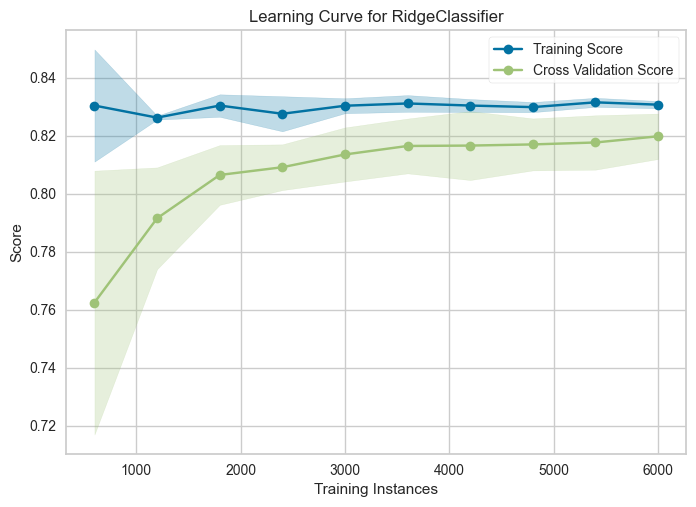

In [11]:
visualizer = (
    LearningCurve(RidgeClassifier(alpha=26500), train_sizes=np.linspace(0.1, 1.0, 10))
    .fit(X_train, y_train)
    .show()
)

Опять же, с оглядкой на масштаб вертикальной оси мы видим, что и уровень эффективности выше, чем в первой модели и разница между двумя эффективностями тоже сократилась. И то и другое - это свидетельство большей обобщающей способности модели.


---

## Диагностика моделей регрессии


Для более реалистичного примера загрузим датасет цен на недвижимость:


In [12]:
from numpy import genfromtxt

dataset = genfromtxt(
    "https://raw.githubusercontent.com/m-mehdi/tutorials/main/boston_housing.csv",
    delimiter=",",
)
X = dataset[:, :-1]
y = dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

Это набор данных для решения задачи регрессии - предсказания цен объектов недвижимости по их характеристикам. Самостоятельно изучите данный датасет, приведите его численные показатели. А мы сразу выведем оценку эффективности простой модели - линейной регрессии:


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [14]:
model = LinearRegression().fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [15]:
print("Linear Regression-Training set score", round(r2_score(y_pred_train, y_train), 3))
print("Linear Regression-Test set score", round(r2_score(y_pred_test, y_test), 3))

Linear Regression-Training set score 0.95
Linear Regression-Test set score 0.667


Большой разрыв между обучающей и тестовой эффективностью также сразу должен навести на мысль о переобучении данной модели. Попробуем проверить наше предположение при помощи кривых обучения (обратите внимание, что мы сразу используем гребневую модель с очень маленькой регуляризацией):


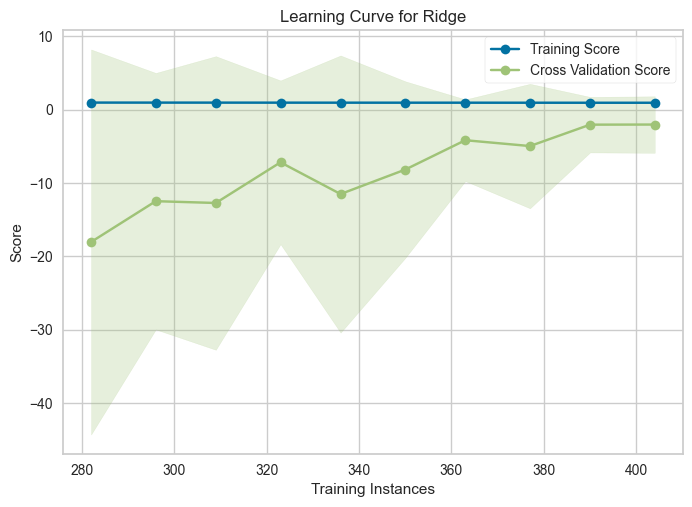

In [16]:
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import Ridge

visualizer = (
    LearningCurve(
        Ridge(alpha=0.0001), scoring="r2", train_sizes=np.linspace(0.7, 1.0, 10)
    )
    .fit(X, y)
    .show()
)


Может потребоваться несколько попыток, чтобы заставить график выглядеть показательно (может понадобится изменить масштаб по разным осям), но в итоге мы можем наблюдать примерно такой график


Обратите внимание, что промежуток между обучающей и тестовой эффективностью все равно очень большой в правой части графика, хоть чисто визуально и не выглядит таковым. Просто тестовая эффективность в левой части графика просто ужасна, и она сильно смещает вертикальную ось вниз. Тем не менее, можно обоснованно предположить, что такая модель переобучается на имеющихся данных.


Сразу построим график зависимости эффективности модели от значения параметра L2-регуляризации:


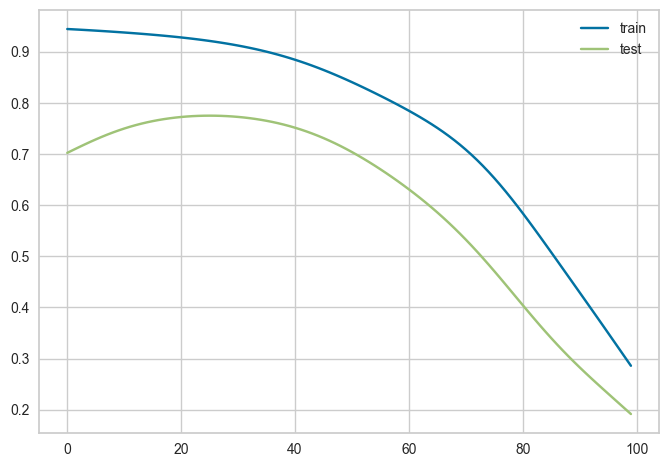

In [17]:
trains = []
tests = []
for i in np.logspace(-2, 3, 100):
    ridge = Ridge(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()


На этом графике очень наглядно виден характер кривых регуляризации. В левой области лежат значения, которые дают слишком сложные модели. Они хорошо описывают обучающую выборку, но не обобщаются на тестовую. Это зона переобучения. В правой области - значения, порождающие слишком простые модели. Они одинаково плохо описывают и обучающую и тестовые выборки. Это зона недообучения. Посередине между ними лежит оптимальный уровень сложности модели для данного конкретного датасета. Здесь эта оптимальность очень хорошо выражена.


Численно можно подобрать оптимальное значение параметра регуляризации для гребневой регрессии. Давайте выведем эффективность такой оптимальной модели:


In [18]:
lr = Ridge(alpha=0.18).fit(X_train, y_train)

print(f"Linear Regression-Training set score: {lr.score(X_train, y_train):.2f}")
print(f"Linear Regression-Test set score: {lr.score(X_test, y_test):.2f}")


Linear Regression-Training set score: 0.92
Linear Regression-Test set score: 0.77


Можно видеть, что они значительно выше, чем у первой модели. Опять же, мы оптимизировали модель за счет борьбы с ее переобучением. Давайте построим кривую обучения данной модели


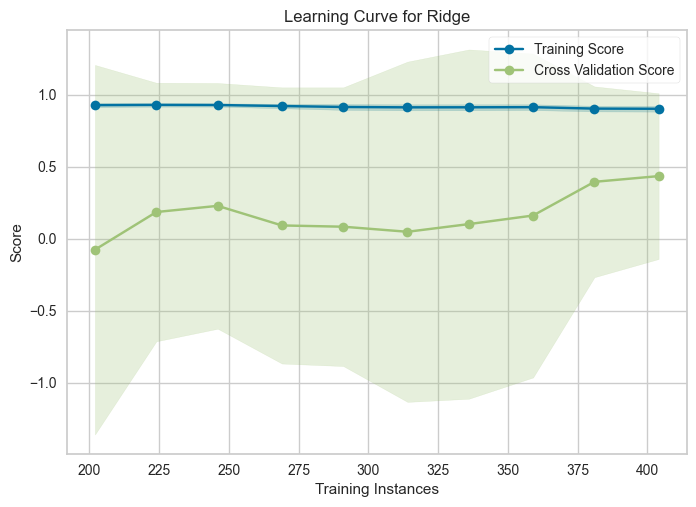

In [19]:
visualizer = (
    LearningCurve(
        Ridge(alpha=0.18), scoring="r2", train_sizes=np.linspace(0.5, 1.0, 10)
    )
    .fit(X, y)
    .show()
)


Опять же, вся разница между кривыми обучения лежит в масштабе вертикальной оси. По сравнению с предыдущим графиком этот выглядит гораздо более адекватно.


Здесь можно заметить, что несмотря на то, что мы подобрали наилучший уровень сложности модели, ее эффективность все равно не идеальна. Присутствует и разница между тестовой и обучающей эффективностью. Это свидетельствует о том, что и в нашей самой лучшей модели все равно имеется и bias и variance в какой-то степени. И хоть мы нашли лучшую модель, она лучшая из одного отдельного класса моделей - гребневой регрессии.


Поэтому можно исследовать на этом же датасете и другие модели. Так, например, можно попробовать другой вид регуляризации - лассо. В библиотеке sklearn эта модель работает только как регрессор, то есть она не подходит для задач классификации. Поэтому мы не могли использовать ее в предыдущем примере. Сразу построим кривые регуляризации:


c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.440e+02, tolerance: 3.233e+00
  model = cd_fast.enet_coordinate_descent(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.449e+02, tolerance: 3.233e+00
  model = cd_fast.enet_coordinate_descent(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.459e+

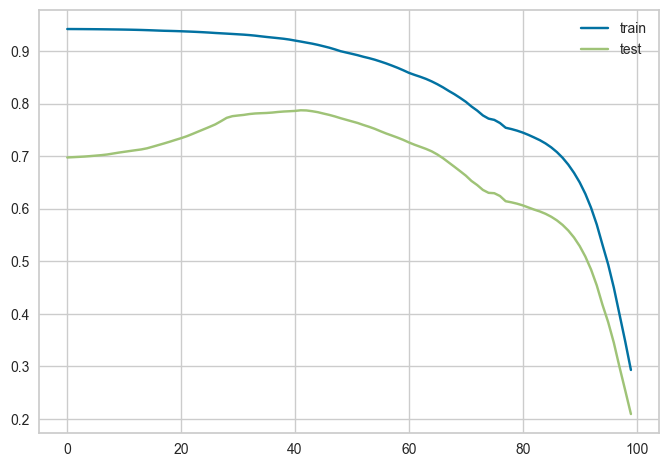

In [20]:
from sklearn.linear_model import Lasso

trains = []
tests = []
for i in np.logspace(-4, 0, 100):
    ridge = Lasso(alpha=i).fit(X_train, y_train)
    trains.append(ridge.score(X_train, y_train))
    tests.append(ridge.score(X_test, y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()


Получается такой график тоже с отчетливыми зонами пере- и недообучения


Точно также можно исследовать и другие виды моделей. Итого для диагностики моделей используется три инструмента:

-   сравнение обучающей и тестовой эффективности
-   анализ формы кривых обучения
-   построение кривых по одному из гиперпараметров модели, который влияет на соотношение bias/variance

Но главное - это сравнение между собой нескольких моделей одного типа, но с разным уровнем сложности (еще говорят про модели с разной склонностью к пере- или недообучению).


---

## Диагностика на реальных данных


В реальных задачах диагностика моделей машинного обучения может быть не настолько очевидной. Зачастую используются модели, которые не используют регуляризацию в явном виде. В этом примере рассмотрим приемы диагностики моделей на реальных данных. Будем использовать известный датасет для классификации "Диабет"


Загружаем данные:


In [21]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv",
    nrows=200,
)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Обратите внимание, что мы считали только первые 200 строк из файла. Этим мы имитируем обучение на части данных. Формируем обучающую и тестовую выборки:


In [22]:
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Для моделирования выберем совершенно другой тип модели - решающие деревья. Создадим объект модели дерева решений и исследуем его эффективность:


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)


Получаем следующий очень показательный результат:


In [24]:
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))


Train score = 1.0000
Test score = 0.5500


Даже без построения кривых обучения здесь очевидно переобучение модели. Но все же для тренировки распознавания разных ситуаций на графике построим кривую обучения:

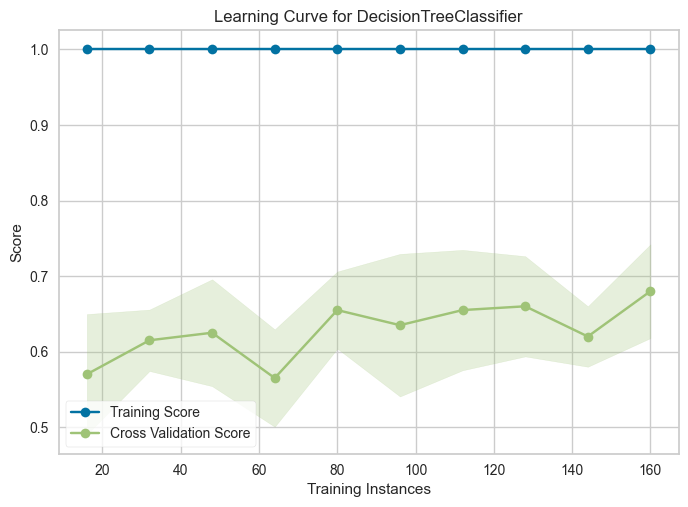

In [25]:
visualizer = (
    LearningCurve(
        DecisionTreeClassifier(random_state=1),
        scoring="accuracy",
        train_sizes=np.linspace(0.1, 1, 10),
    )
    .fit(X, y)
    .show()
)


У деревьев решений один из параметров - максимальная глубина дерева как раз и влияет на склонность модели к переобучению. Аналогом регуляризации для деревьев будет искусственное ограничение максимальной глубины дерева. Давайте построим кривую обучения для такого регуляризованного дерева:

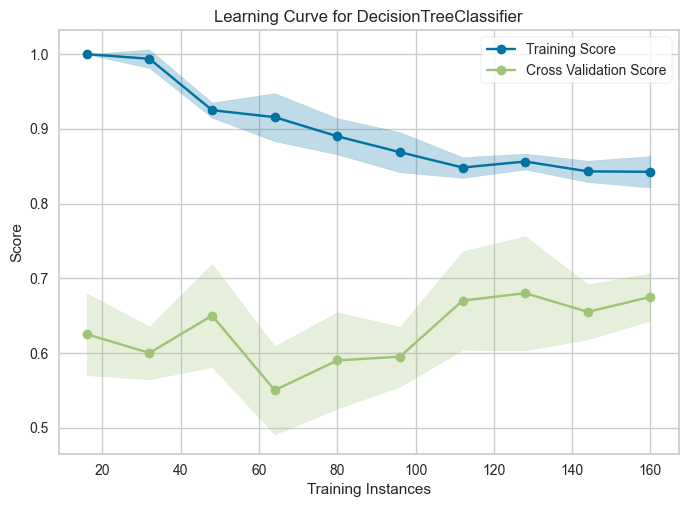

In [26]:
visualizer = (
    LearningCurve(
        DecisionTreeClassifier(max_depth=4), train_sizes=np.linspace(0.1, 1.0, 10)
    )
    .fit(X, y)
    .show()
)


Выведя метрики эффективности получаем более высокое качество модели на тестовых данных:

In [27]:
from sklearn.metrics import f1_score

In [28]:
model = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train f1_score = %.4f" % f1_score(y_train, y_train_pred))
print("Train f1_score = %.4f" % f1_score(y_test, y_pred))


Train f1_score = 0.7600
Train f1_score = 0.5455


Введение регуляризации, искусственное упрощение моделей - не единственный способ борьбы с переобучением. Самый лучший способ - это обучение на более полном датасете, то есть добавление большого количества данных. В этом примере мы специально не использовали весь имеющийся набор данных. На части модель сильно переобучается, но чем больше данных, тем меньше модели (даже одинаковые по сложности) становятся склонными к переобучению.

Для иллюстрации этого повторим обучение нерегуляризованного дерева решений на всем датасете:

In [29]:
df = pd.read_csv('https://raw.githubusercontent.com/koroteevmv/ML_course/2023/ML4.3%20diagnostics/diabetes.csv')
target = "Outcome"
y = df[target]
X = df.drop(target, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

В итоге мы получаем такие метрики эффективности:

In [30]:

from sklearn.metrics import f1_score
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))

Train score = 1.0000
Test score = 0.7273



Получившаяся модель значительно лучше, чем даже регуляризованное дерево. В общем случае, добавление данных работает лучше, чем регуляризация.

---
## Диагностика недообучения

До сих пор мы рассматривали примеры, в которых модели по умолчанию демонстрируют явное переобучение. Но на практике чаще сталкиваются с недообучением, так как начинают анализ с более простых моделей, которые как раз склонны именно к недообучению. Рассмотрим в качестве примера более сложный датасет.


В sklearn есть встроенный механизм загрузки датасетов из онлайн репозитория OpenML. Возьмем оттуда датасет, посвященный проблеме управления истребителем F16:

In [31]:
from sklearn.datasets import fetch_openml

data = fetch_openml(name="delta_ailerons", parser="auto")
data.data.shape


(7129, 5)

Сформируем обучающую и тестовую выборки:

In [32]:
X = pd.get_dummies(data.data)
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Создадим и оценим простую модель логистической регрессии:

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))


Train score = 0.6092
Test score = 0.5989


Построим кривую обучения данной модели:

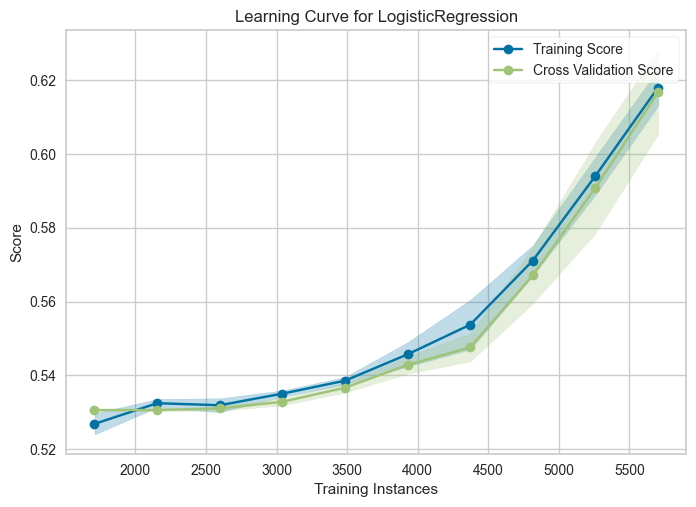

In [34]:
visualizer = (
    LearningCurve(
        LogisticRegression(), scoring="accuracy", train_sizes=np.linspace(0.3, 1.0, 10)
    )
    .fit(X, y)
    .show()
)


Здесь очевидны признаки недообучения: 
- низкий уровень обучающей эффективности, 
- малый разрыв между обучающей и тестовой эффективностью. 

При недообучении регуляризация не поможет, даже навредит, так как еще усилит его. Поэтому единственный путь в этом случае - использовать более сложные, вариативные модели. Можно, например, попробовать многослойный перцептрон:

In [35]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier().fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))


Train score = 0.9393
Test score = 0.9390


c:\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Самого главного мы добились - эффективность модели сильно выросла. Но давайте построим график обучения

c:\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\n

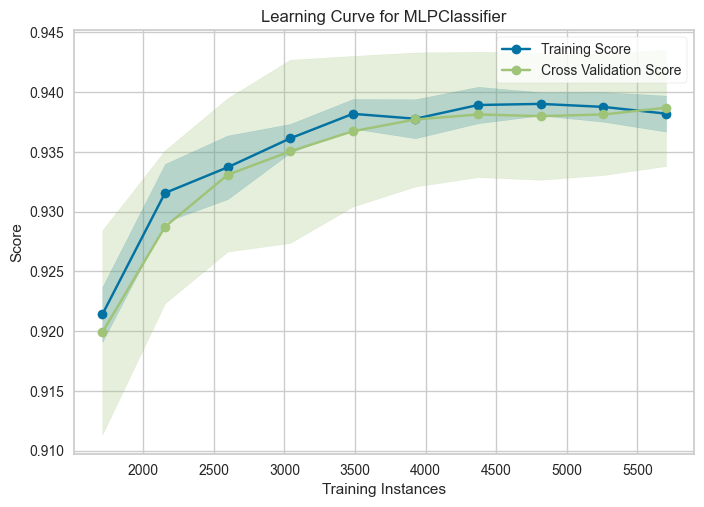

In [36]:
visualizer = (
    LearningCurve(
        MLPClassifier(), scoring="accuracy", train_sizes=np.linspace(0.3, 1.0, 10)
    )
    .fit(X, y)
    .show()
)


Кроме использования более вариативных моделей самих по себе можно ввести в модель полиномиальные признаки:

In [37]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures

model = RidgeClassifier(alpha=0.001).fit(
    PolynomialFeatures(2).fit_transform(X_train), y_train
)
y_train_pred = model.predict(PolynomialFeatures(2).fit_transform(X_train))
y_pred = model.predict(PolynomialFeatures(2).fit_transform(X_test))
print("Train score = %.4f" % accuracy_score(y_train, y_train_pred))
print("Test score = %.4f" % accuracy_score(y_test, y_pred))


Train score = 0.9392
Test score = 0.9362


Полиномиальные модели являются естественным усложнением линейных и поэтому в случае недообучения исходной модели почти всегда обеспечивают увеличение эффективности модели

Для этой полиномиальной модели уже можно пробовать использовать регуляризацию и строить соответствующие кривые:

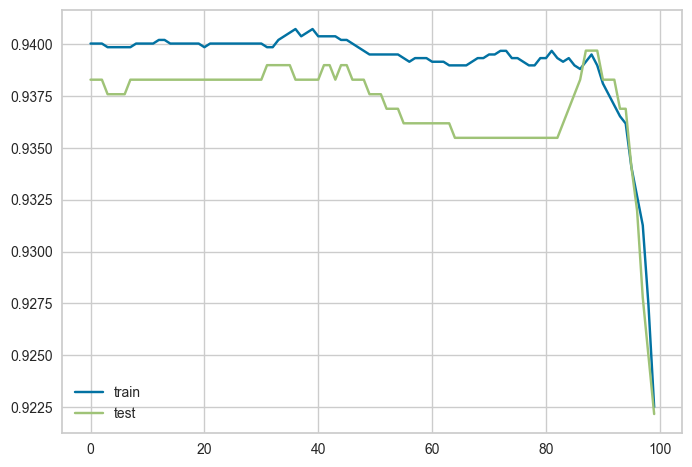

In [38]:
from sklearn.linear_model import RidgeClassifier

trains = []
tests = []
for i in np.logspace(-7, 0, 100):
    ridge = RidgeClassifier(alpha=i).fit(
        PolynomialFeatures(2).fit_transform(X_train), y_train
    )
    trains.append(ridge.score(PolynomialFeatures(2).fit_transform(X_train), y_train))
    tests.append(ridge.score(PolynomialFeatures(2).fit_transform(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()


В этом примере (как и во многих других реальных случаях) кривая регуляризации уже не такая очевидная и легко читаемая. Но и на ней можно при желании разглядеть область недообучения справа. Область переобучения здесь просматривается не так четко, так как тестовая эффективность практически не падает с уменьшением параметра регуляризации:



Также можно заметить, что этот график уже не такой гладкий и ровный, как в предыдущих примерах. На нем присутствуют скачки, неравномерности. Это все случайные отклонения, которые обусловлены и артефактами в самих данных, и стохастичностью процесса обучения сложных моделей и случайными ошибками выборки, возникшими при разделении датасета на тестовую и обучающую выборки.

---
# Домашнее задание

---
## Задания для самостоятельного выполнения

1) Повторите диагностику модели классификации синтетических данных с использованием других метрик эффективности - precision, recall, F1. Как изменились результаты?


In [39]:

X, y = make_classification(
    n_samples=1000,
    n_features=30,
    n_informative=25,
    n_repeated=0,
    class_sep=1,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3
)


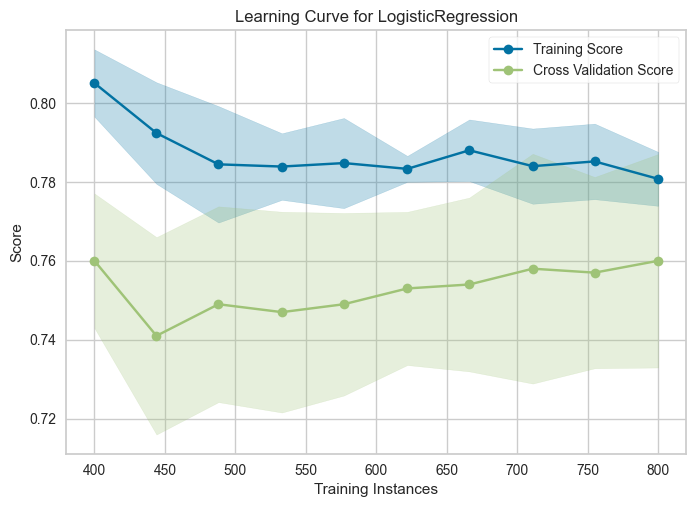

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [40]:
# Accuracy
LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10), scoring="accuracy"
).fit(X, y).show()

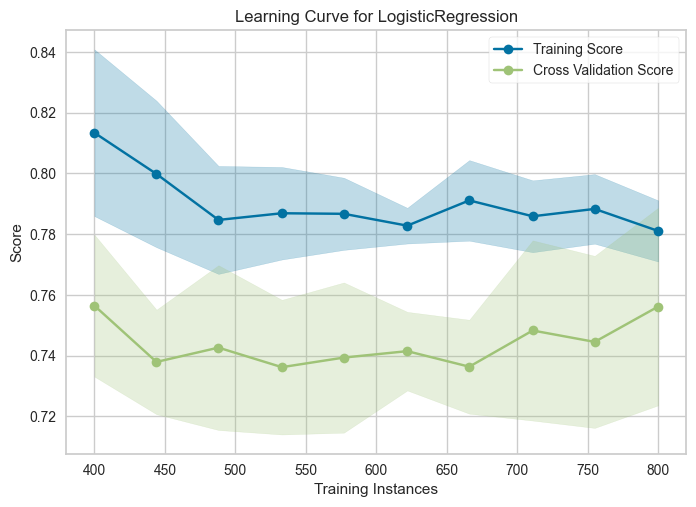

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [41]:
# Precision
LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10), scoring="precision"
).fit(X, y).show()


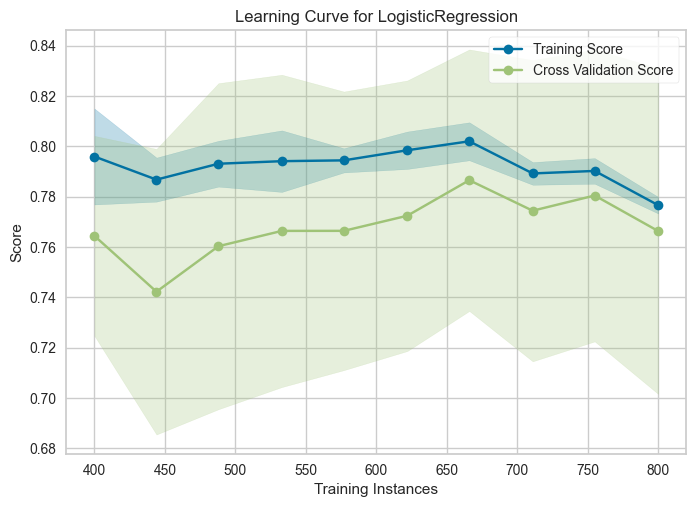

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [42]:
# Recall
LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10), scoring="recall"
).fit(X, y).show()


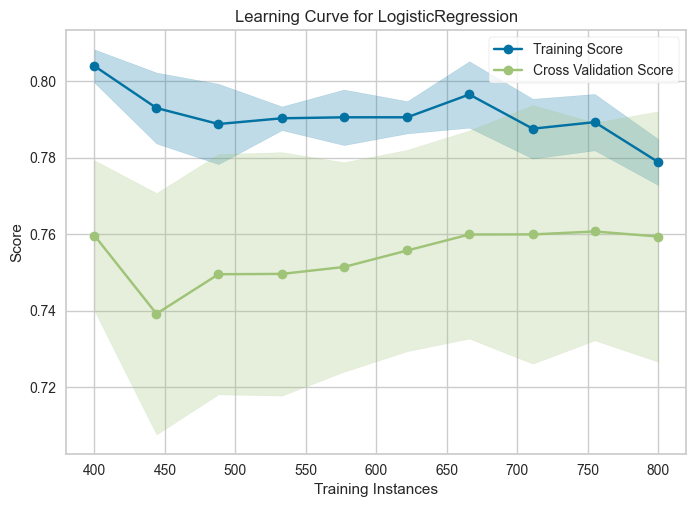

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [43]:
# F1
LearningCurve(
    LogisticRegression(), train_sizes=np.linspace(0.5, 1.0, 10), scoring="f1"
).fit(X, y).show()


2) Повторите диагностику модели регрессии с использованием других видов моделей:
    1) метода опорных векторов (исследуйте влияние параметра С на недо-и переобучение)
    2) метода ближайших соседей (исследуйте влияние количества соседей)
    3) метода решающих деревьев (гиперпараметры по вашему выбору)

In [44]:
from sklearn.svm import SVR

In [45]:
X, y = make_regression(
    n_samples=1000,
    n_features=30,
    n_informative=25,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3
)


**Метод опорных векторов**

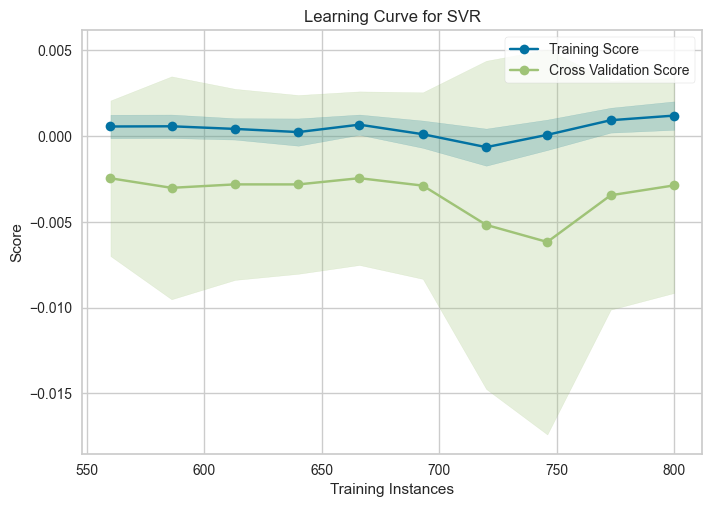

<Axes: title={'center': 'Learning Curve for SVR'}, xlabel='Training Instances', ylabel='Score'>

In [46]:
LearningCurve(SVR(C=0.05), train_sizes=np.linspace(0.7, 1.0, 10)).fit(
    X, y
).show()

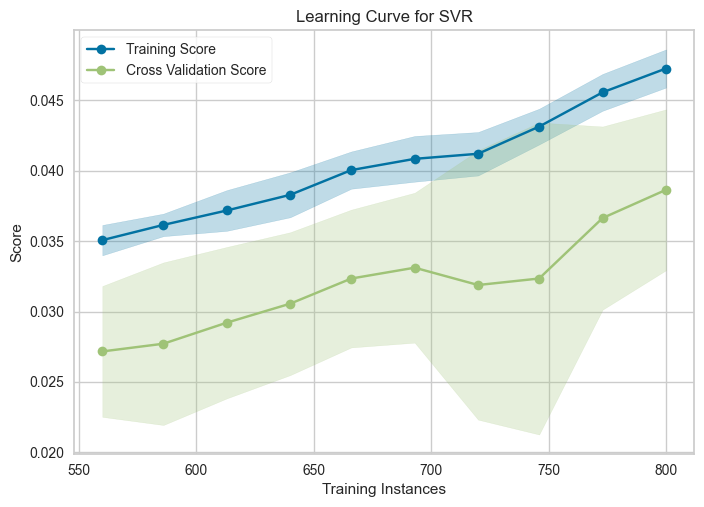

<Axes: title={'center': 'Learning Curve for SVR'}, xlabel='Training Instances', ylabel='Score'>

In [47]:
LearningCurve(SVR(C=1), train_sizes=np.linspace(0.7, 1.0, 10)).fit(X, y).show()


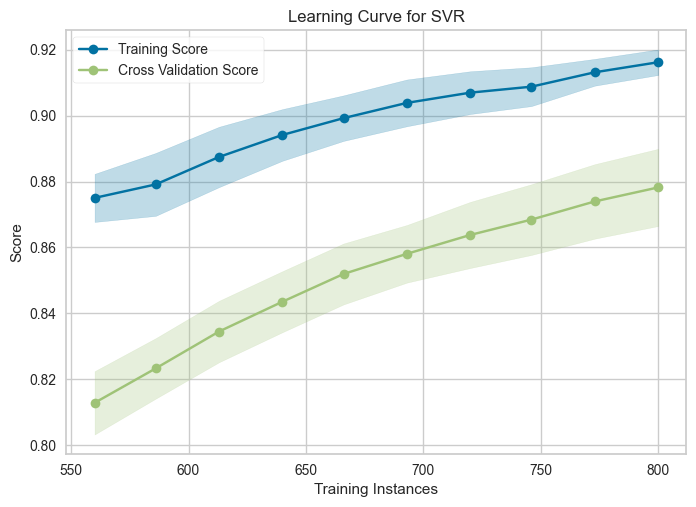

<Axes: title={'center': 'Learning Curve for SVR'}, xlabel='Training Instances', ylabel='Score'>

In [48]:
LearningCurve(SVR(C=40), train_sizes=np.linspace(0.7, 1.0, 10)).fit(X, y).show()


<span style="color: cyan">Как видно, чем больше C, тем меньше переобучение модели</span>

**Метод ближайших соседей**

In [49]:
from sklearn.neighbors import KNeighborsRegressor

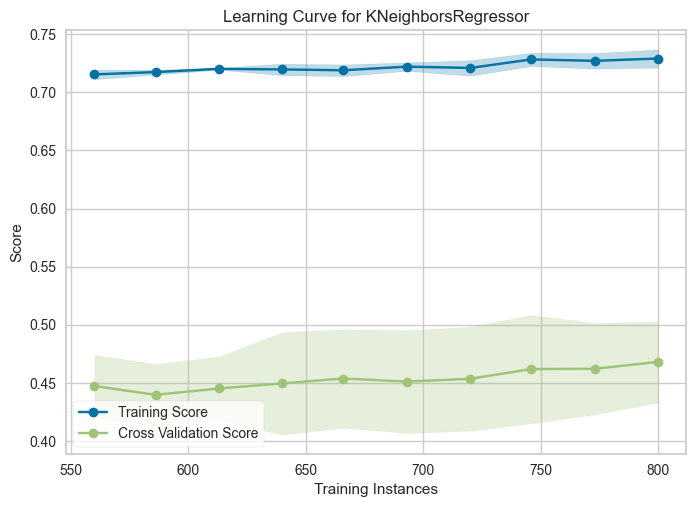

<Axes: title={'center': 'Learning Curve for KNeighborsRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [50]:
LearningCurve(KNeighborsRegressor(n_neighbors=3), train_sizes=np.linspace(0.7, 1.0, 10)).fit(
    X, y
).show()


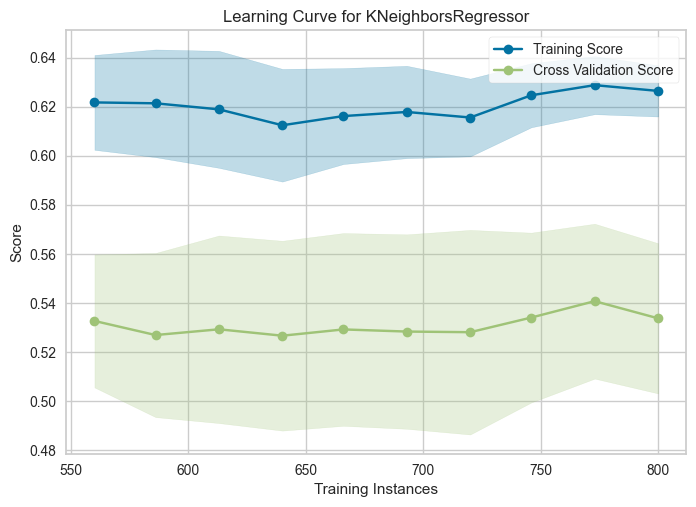

<Axes: title={'center': 'Learning Curve for KNeighborsRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [51]:
LearningCurve(KNeighborsRegressor(n_neighbors=10), train_sizes=np.linspace(0.7, 1.0, 10)).fit(
    X, y
).show()


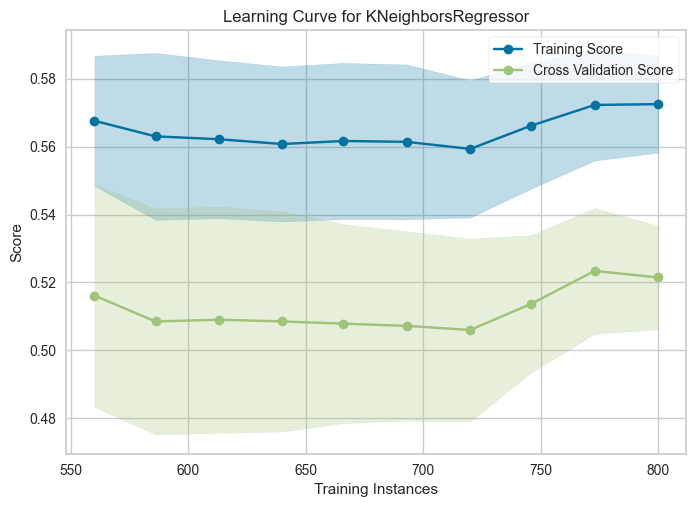

<Axes: title={'center': 'Learning Curve for KNeighborsRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [52]:
LearningCurve(KNeighborsRegressor(n_neighbors=20), train_sizes=np.linspace(0.7, 1.0, 10)).fit(
    X, y
).show()


<span style="color: cyan">Чем больше соседей, тем меньше переобучение модели, и начинается недообучение</span>

---
3) Дополните анализ датасета Бостон исследованием модели лассо - постройте кривые обучения для переобученной, недообученной и качественной модели, найдите оптимальное значение параметра регуляризации в модели лассо.

In [53]:
from sklearn.datasets import fetch_openml

In [54]:
boston = fetch_openml("boston")
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=3
)


c:\Programs\Python\Python312\Lib\site-packages\sklearn\datasets\_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=531
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=853

  warn(warning_msg)


In [55]:
from sklearn.linear_model import Lasso

c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1351: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.408e+03, tolerance: 3.242e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.en

c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Las

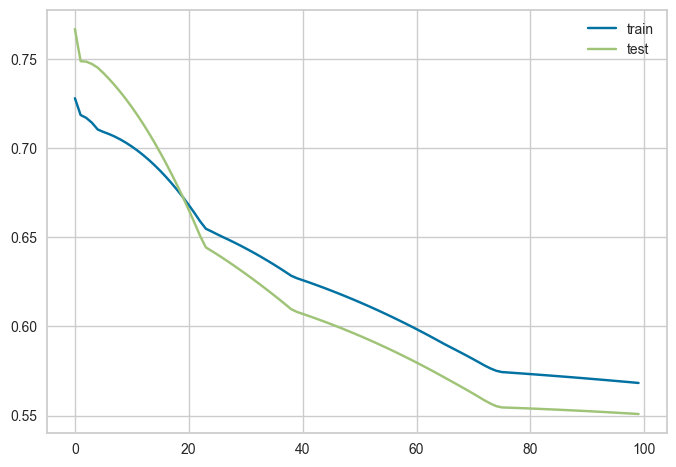

In [56]:
trains = []
tests = []
for i in np.linspace(0, 5, 100):
    lasso = Lasso(alpha=i).fit(X_train, y_train)
    trains.append(lasso.score(np.array(X_train), y_train))
    tests.append(lasso.score(np.array(X_test), y_test))

plt.plot(trains, label="train")
plt.plot(tests, label="test")
plt.legend()


In [57]:
import warnings

warnings.filterwarnings("ignore")


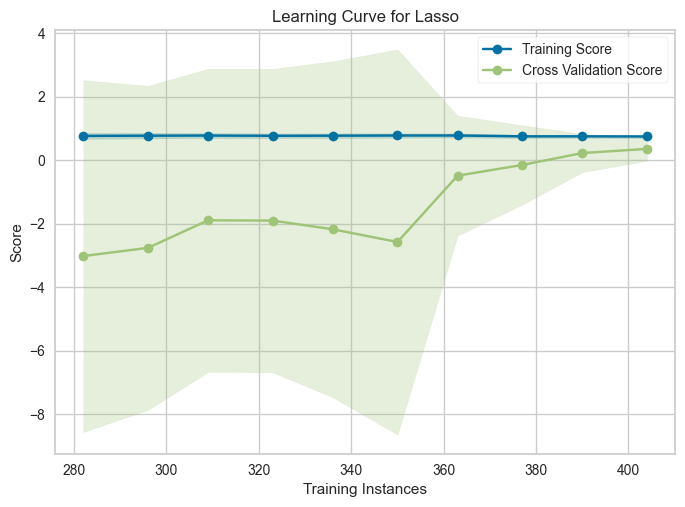

<Axes: title={'center': 'Learning Curve for Lasso'}, xlabel='Training Instances', ylabel='Score'>

In [58]:
LearningCurve(Lasso(alpha=0), train_sizes=np.linspace(0.7, 1.0, 10), scoring="r2").fit(np.array(X), y).show()

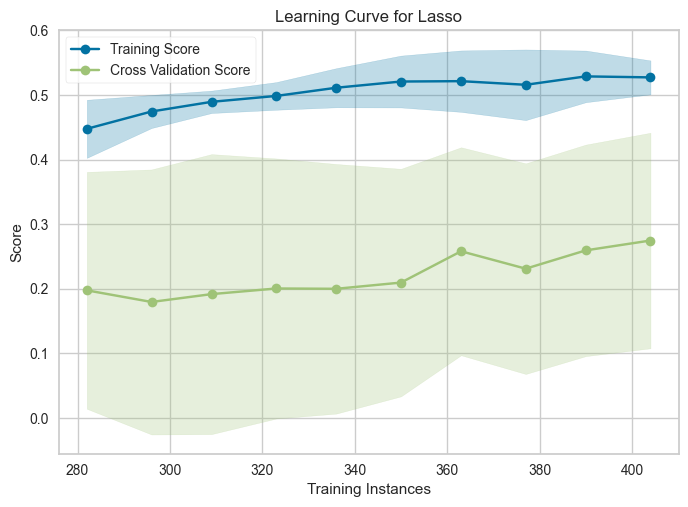

<Axes: title={'center': 'Learning Curve for Lasso'}, xlabel='Training Instances', ylabel='Score'>

In [59]:
LearningCurve(Lasso(alpha=10), train_sizes=np.linspace(0.7, 1.0, 10), scoring="r2").fit(np.array(X), y).show()

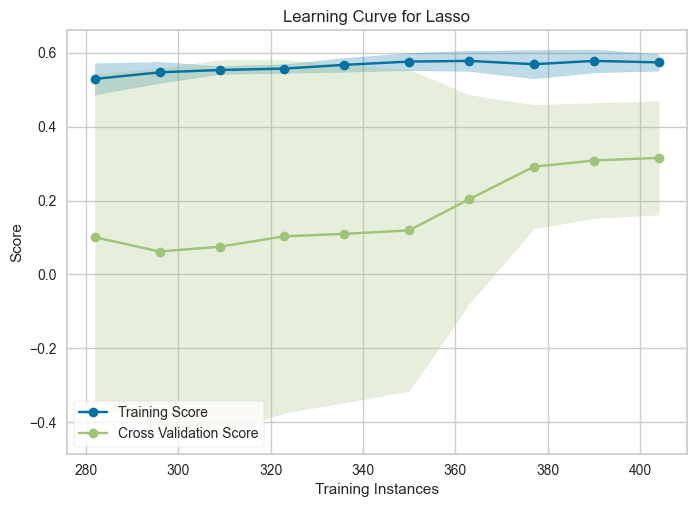

<Axes: title={'center': 'Learning Curve for Lasso'}, xlabel='Training Instances', ylabel='Score'>

In [60]:
LearningCurve(Lasso(alpha=4), train_sizes=np.linspace(0.7, 1.0, 10), scoring="r2").fit(np.array(X), y).show()

Изначально у модели высокое переобучение, но чем больше `alpha`, тем сильнее недообучение

---
4) В одном из двух первых примеров используйте модель ElasticNet и исследуйте влияние сразу двух параметров регуляризации на эффективность модели.


In [61]:
from sklearn.linear_model import ElasticNet

In [62]:
matr = np.zeros((10, 10))

In [63]:
for n, l1 in enumerate(np.linspace(0, 1, 10, endpoint=True)):
    for k, alpha in enumerate(np.linspace(0, 100, 10, endpoint=True)):
        model = ElasticNet(l1_ratio=l1, alpha=alpha).fit(X_train, y_train)
        matr[n, k] = model.score(np.array(X_test), y_test)

In [64]:
import seaborn as sns

<Axes: >

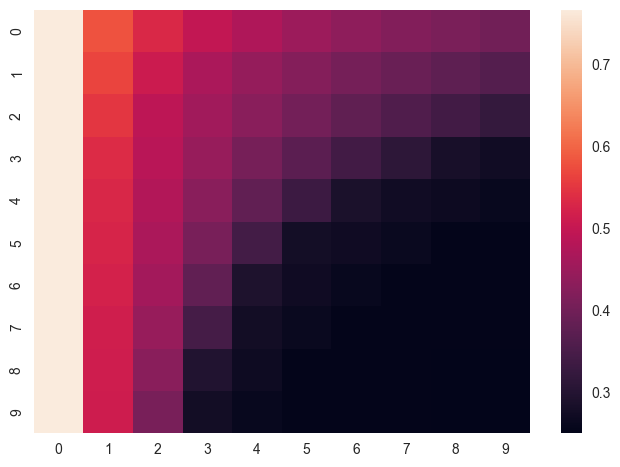

In [65]:
sns.heatmap(matr)

5) Дополните анализ дерева решений из третьего примера: постройте кривые регуляризации для полного датасета, найдите оптимальную глубину дерева и оцените качество такой модели на всем датасете. Повторите данный анализ используя в качестве метрики эффективности F1.

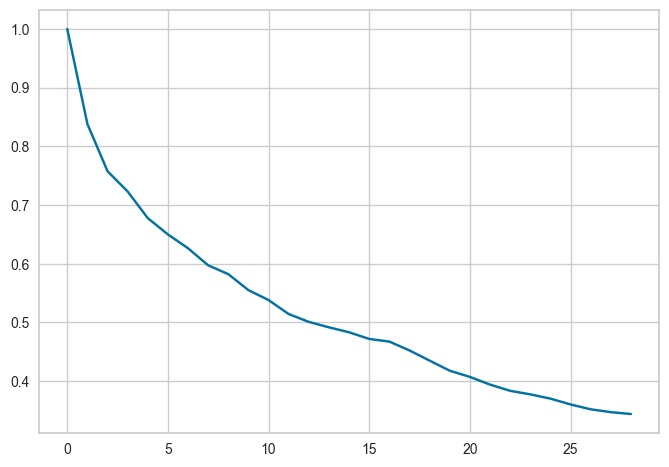

In [81]:
mas = []
for neighbors in range(1, 30):
    model = KNeighborsRegressor(neighbors).fit(X, y)
    size = slice(None, -int(len(X) * 0.2))
    # Обучаем на 80% датасета
    mas.append(model.score(X[size], y[size]))

plt.plot(mas)


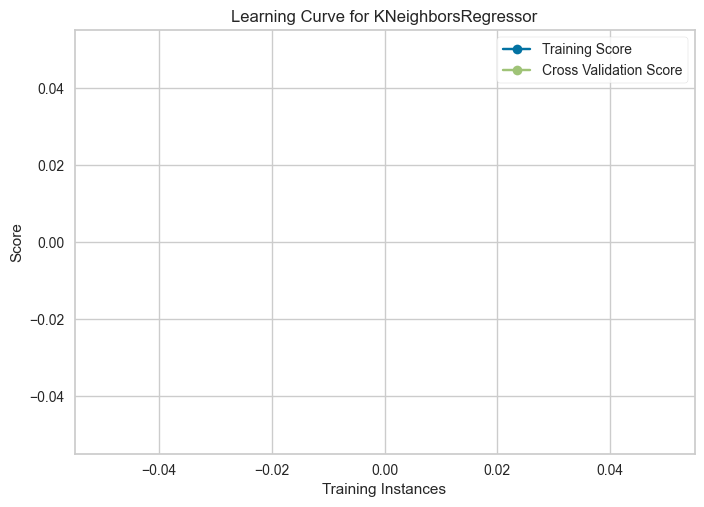

<Axes: title={'center': 'Learning Curve for KNeighborsRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [90]:

LearningCurve(KNeighborsRegressor(10), scoring='f1').fit(X, y).show()

6) Повторите анализ на других реальных датасетах из репозитория OpenML:
    - phoneme
    - banknote-authentication
    - delta_ailerons
    - mammography
    - electricity
    - mozilla4
    - kropt
    - nursery
    - volcanoes-b3

In [99]:
# Берем датасет
dataset = fetch_openml("phoneme")
X, y = dataset.data, dataset.target

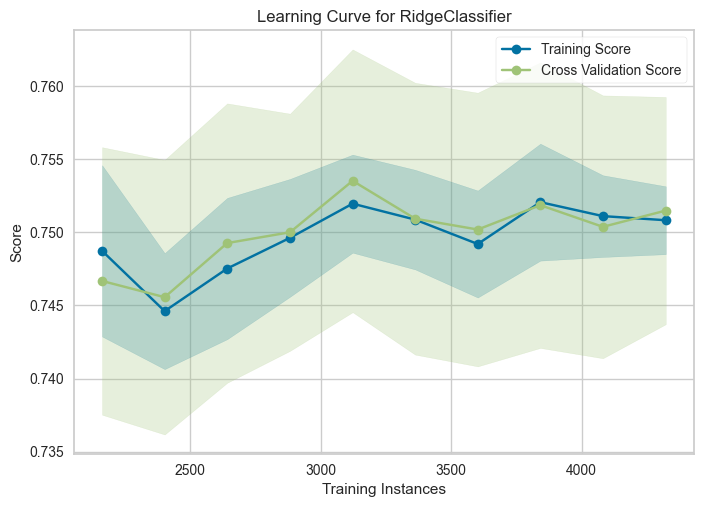

<Axes: title={'center': 'Learning Curve for RidgeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [100]:
LearningCurve(RidgeClassifier(), train_sizes=np.linspace(0.5, 1, 10)).fit(X, y).show()

In [101]:
from sklearn.neighbors import KNeighborsClassifier

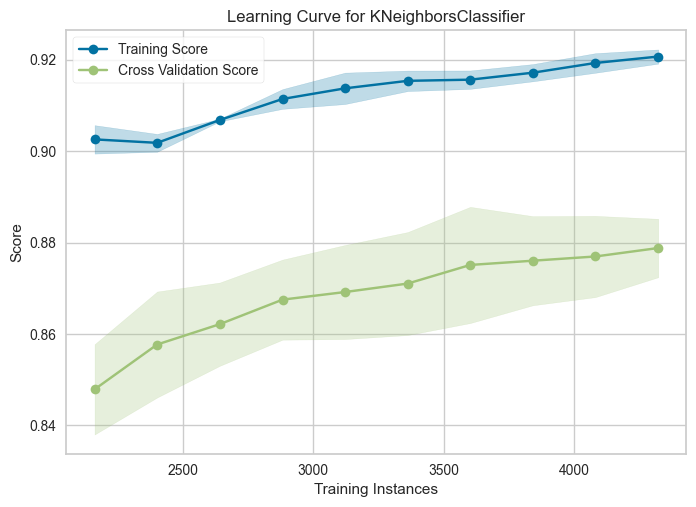

<Axes: title={'center': 'Learning Curve for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [106]:
LearningCurve(KNeighborsClassifier(), train_sizes=np.linspace(0.5, 1, 10)).fit(
    X, y
).show()

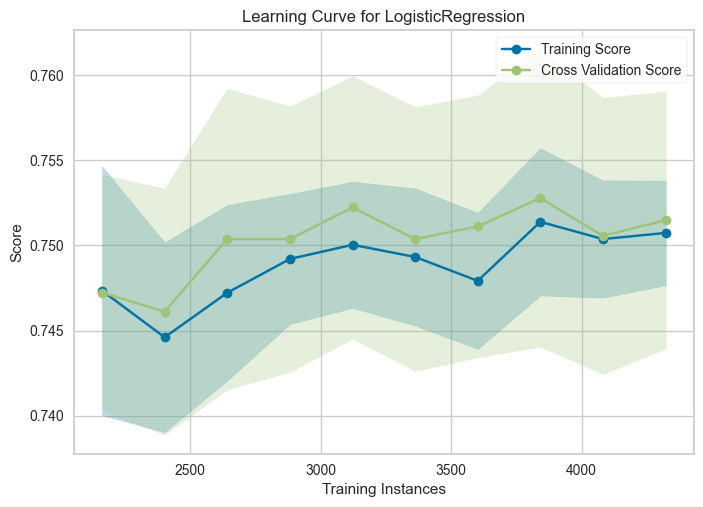

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [107]:
LearningCurve(LogisticRegression(), train_sizes=np.linspace(0.5, 1, 10)).fit(
    X, y
).show()


---
## Контрольные вопросы
1) Что такое обобщающая способность модели?
2) Что такое переобучение модели?
3) Какие есть способы борьбы с переобучением?
4) Что такое регуляризация модели, как она работает?
5) Чем отличаются разные методы регуляризации моделей?
6) Что такое недообучение модели?
7) Какие есть способы борьбы с недообучением?

---
## Дополнительные задания

1) Повторите анализ последнего примера но с другими разделениями датасета на обучающую и тестовую выборки (изменяйте параметр random_state). Как меняется вид графиков?

2) Напишите код построения кривых регуляризации, использующий кросс-валидацию.